# Using Python tools for a analysis of COVID-19 data

# ARIMA method to forecast

#### Source: https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option("display.precision", 5)
pd.set_option('display.max_rows', 15)

### <span style="color:red">Analysis of the last N days</span>

In [3]:
Ndays = '150days'

### <span style="color:red">Day range for matplotlib</span>

In [4]:
Ninterval = 10

In [5]:
url = 'https://covid.ourworldindata.org/data/owid-covid-data.csv'

In [6]:
filename = '/home/davi/Documents/Python/Covid-19-Data/owid-covid-data.csv'

In [7]:
# df = pd.read_csv(url)
df = pd.read_csv(filename)
df['date'] = pd.to_datetime(df['date'])
df['location'] = df['location'].replace(['United States'],'United_States')
df['location'] = df['location'].replace(['United Kingdom'],'United_Kingdom')

In [8]:
df = df.loc[:,['date', 'location', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
df = df[df['date'] > pd.to_datetime("today") - pd.to_timedelta(Ndays)]
df = df.sort_values(by=['total_cases'], ascending=True)

# Number of cases and deaths in World

In [9]:
dfWorld = df[df['location'] == 'World']
dfWorld = dfWorld.sort_values(by='date', ascending=True)
dfWorld = dfWorld.loc[:,['date', 'total_cases', 'total_deaths', 'new_cases', 'new_deaths']]
dfWorld.reset_index(drop=True, inplace=True)
dfWorld

,date,total_cases,total_deaths,new_cases,new_deaths
0,2020-03-23,356230.0,14736.0,34402.0,1675.0
1,2020-03-24,400559.0,16581.0,44329.0,1845.0
2,2020-03-25,442984.0,18885.0,42425.0,2304.0
3,2020-03-26,496652.0,21499.0,53668.0,2614.0
4,2020-03-27,557677.0,24308.0,61025.0,2809.0
...,...,...,...,...,...
131,2020-08-01,17580519.0,679488.0,278896.0,6209.0
132,2020-08-02,17842650.0,685265.0,262131.0,5777.0
133,2020-08-03,18065526.0,689235.0,222876.0,3970.0
134,2020-08-04,18269636.0,693733.0,204110.0,4498.0


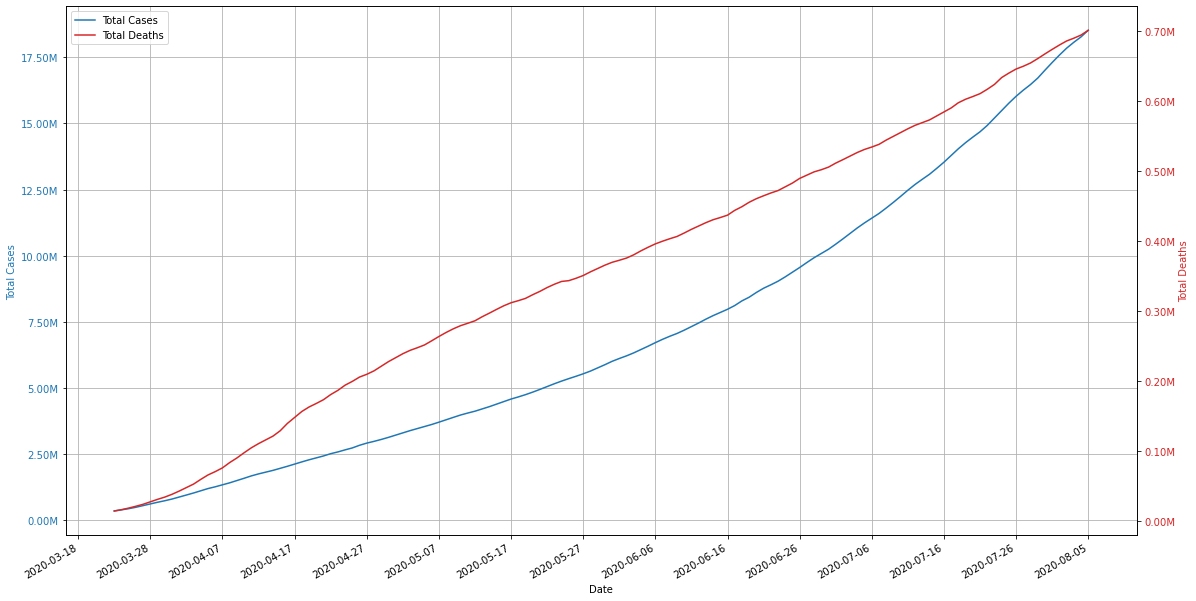

In [10]:
fig, ax1 = plt.subplots(figsize=(19.20,10.80))

color = 'tab:blue'
ax1.plot(dfWorld.date, dfWorld.total_cases, color=color, label='Total Cases')
ax1.set_xlabel('Date')
ax1.set_ylabel('Total Cases', color=color)
ax1.tick_params(axis='y', labelcolor=color)
plt.ticklabel_format(style='plain', axis='y')
plt.grid()
ax2 = ax1.twinx()

color = 'tab:red'
ax2.plot(dfWorld.date, dfWorld.total_deaths, color=color, label = 'Total Deaths')
ax2.set_xlabel('Date')
ax2.set_ylabel('Total Deaths', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, pos: '{:,.2f}'.format(y/1000000) + 'M'))
plt.gcf().autofmt_xdate()

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax.transAxes)

plt.show()

###  Daily deaths [WORLD]

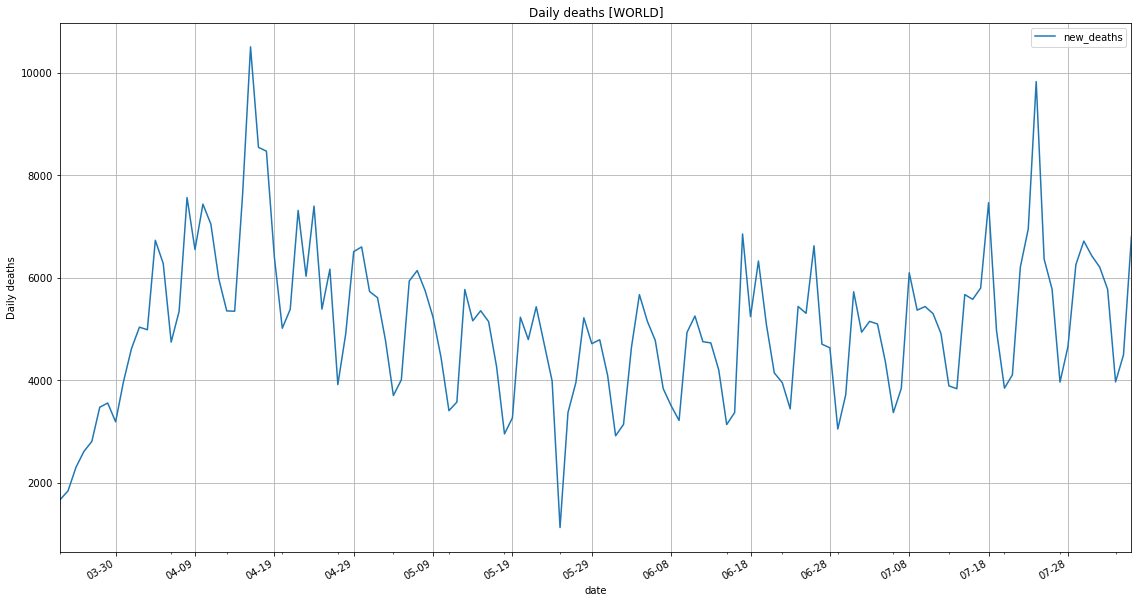

In [11]:
dfWorld.plot(x='date', y='new_deaths', figsize=(19.20,10.80))

plt.ylabel('Daily deaths')
plt.title('Daily deaths [WORLD]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

### Daily cases [WORLD]

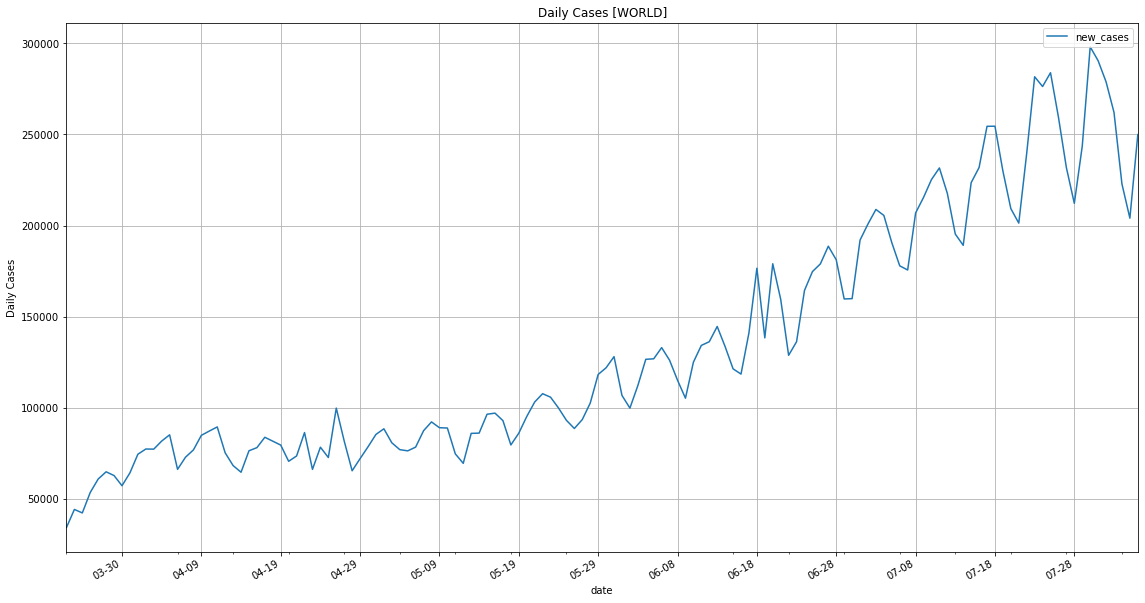

In [12]:
dfWorld.plot(x='date', y='new_cases', figsize=(19.20,10.80))

plt.ylabel('Daily Cases')
plt.title('Daily Cases [WORLD]')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=Ninterval))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.ticklabel_format(style='plain', axis='y', scilimits=(0,0))
plt.gcf().autofmt_xdate()

plt.grid()
plt.show()

In [13]:
nameColumns = list(dfWorld.columns)

In [14]:
# for index in range(len(nameColumns)):
#     fig, ax = plt.subplots(figsize=(19.20,10.80))

#     ax.plot(dfWorld.date, y[index])
#     ax.set_xlabel('Date')
#     ax.set_ylabel(nameColumns[index])
#     plt.title(nameColumns[index])
     
#     ax = plt.gca()
#     ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
#     plt.gcf().autofmt_xdate()

#     print()
#     plt.show()

In [15]:
scaler  = MinMaxScaler(feature_range=(0,1))

In [16]:
dfScaled = dfWorld
dfScaled[['total_cases','total_deaths','new_cases','new_deaths']] = scaler.fit_transform(dfWorld[['total_cases','total_deaths','new_cases','new_deaths']])
dfScaled = dfScaled.set_index('date')
dfScaled

,total_cases,total_deaths,new_cases,new_deaths
date,,,,
2020-03-23,0.00000,0.00000,0.00000,0.05804
2020-03-24,0.00244,0.00269,0.03765,0.07618
2020-03-25,0.00478,0.00605,0.03043,0.12515
2020-03-26,0.00773,0.00986,0.07307,0.15822
2020-03-27,0.01109,0.01396,0.10097,0.17902
...,...,...,...,...
2020-08-01,0.94830,0.96930,0.92724,0.54177
2020-08-02,0.96273,0.97773,0.86366,0.49568
2020-08-03,0.97500,0.98352,0.71478,0.30289


In [17]:
nameColumns = list(dfScaled.columns)

In [18]:
# dfWorld = dfWorld[-180:]

In [19]:
y={}
for index in range(len(nameColumns)):
    y[index] = dfScaled[nameColumns[index]]
    y[index] = y[index].fillna(y[index].bfill())

In [20]:
y = y[2]
y

date
2020-03-23    0.00000
2020-03-24    0.03765
2020-03-25    0.03043
2020-03-26    0.07307
2020-03-27    0.10097
               ...   
2020-08-01    0.92724
2020-08-02    0.86366
2020-08-03    0.71478
2020-08-04    0.64361
2020-08-05    0.81743
Name: new_cases, Length: 136, dtype: float64

In [21]:
# y = dfScaled['total_deaths'].resample('D').mean()
# # y = dfWorld['new_cases']
# y = y.fillna(y.bfill())

In [22]:
p = d = q = range(0, 2)

In [23]:
pdq = list(itertools.product(p, d, q))

In [24]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [25]:
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [26]:
# warnings.filterwarnings("ignore")
# for param in pdq:
#     for param_seasonal in seasonal_pdq:
#         try:
#                 mod = sm.tsa.statespace.SARIMAX(y[index],
#                                                 order=param,
#                                                 seasonal_order=param_seasonal,
#                                                 enforce_stationarity=False,
#                                                 enforce_invertibility=False)

#                 results = mod.fit()
#             print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
#         except:
#             print('PAU')
#             continue

In [27]:
warnings.filterwarnings("ignore")
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:172.80715217812036
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:54.70603423150308
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-165.36561408712848
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-151.87196504200296
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-203.83259549781084
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-239.70345582156696
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-153.64969431334816
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-153.29974249278314
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10.706959591466877
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-78.03880162162041
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-242.0003042223806
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-207.1665416628462
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-260.225249917522
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-295.0526044597096
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-212.0774814448035
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-205.71532092913503
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-366.04933863754036
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-331.

In [28]:
mod = sm.tsa.statespace.SARIMAX(y,
                               order=(0,0,1),
                               seasonal_order=(1,1,1,12),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

# ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:34.87146228951575

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7308      0.066     10.992      0.000       0.601       0.861
ar.S.L12      -0.3202      0.504     -0.636      0.525      -1.308       0.667
ma.S.L12       0.3734      0.497      0.751      0.453      -0.601       1.348
sigma2         0.0083      0.001      8.601      0.000       0.006       0.010


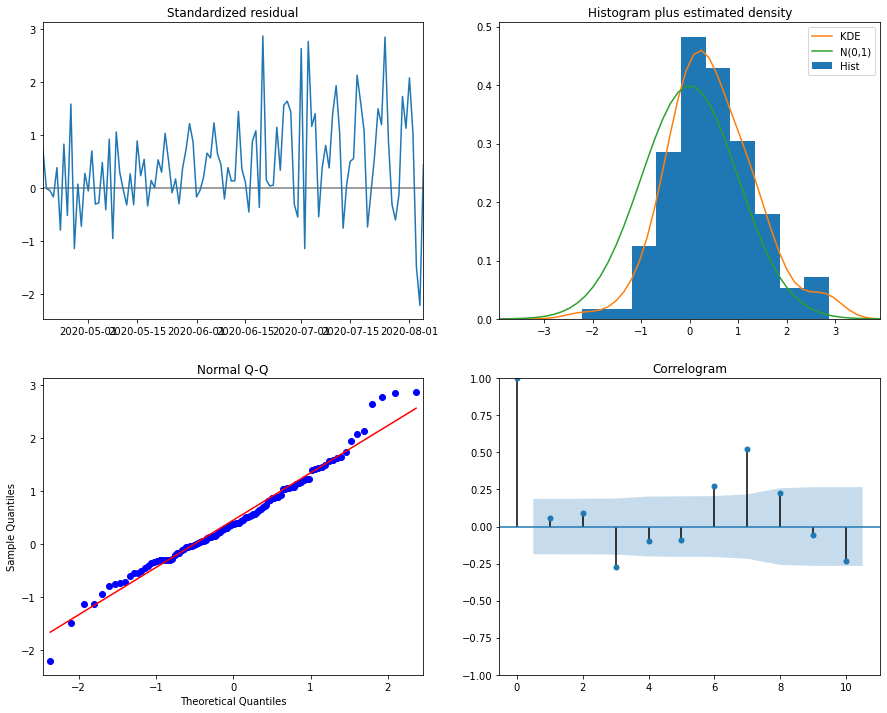

In [29]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

In [30]:
pred = results.get_prediction(start=pd.to_datetime('2020-07-15'), dynamic=False)
pred_ci = pred.conf_int()

In [31]:
pred_ci

,lower new_cases,upper new_cases
2020-07-15,0.49333,0.84962
2020-07-16,0.51987,0.87616
2020-07-17,0.46260,0.81888
2020-07-18,0.50840,0.86469
2020-07-19,0.46490,0.82119
...,...,...
2020-08-01,0.55982,0.91611
2020-08-02,0.59046,0.94675
2020-08-03,0.67130,1.02759
2020-08-04,0.66632,1.02261


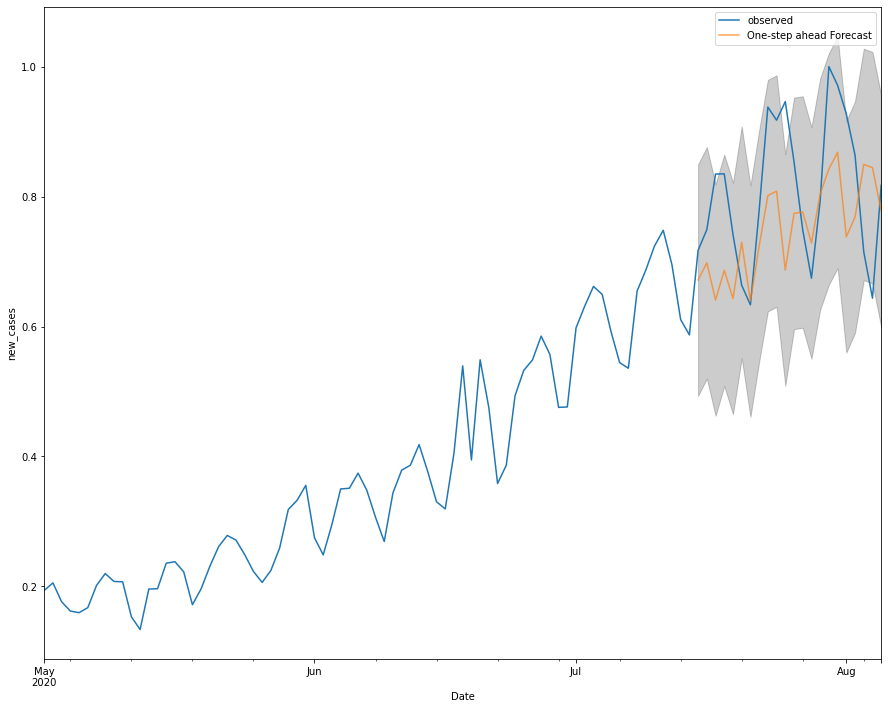

In [32]:
ax = y['2020-05':].plot(label='observed', figsize=(15,12))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
               pred_ci.iloc[:,0],
               pred_ci.iloc[:,1],color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('new_cases')
plt.legend()
plt.show()

In [33]:
y_forecasted = pred.predicted_mean
y_truth = y['2020-07-15':]

In [34]:
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error (MSE) of our forecast is {}'.format(round(mse, 2)))

The Mean Squared Error (MSE) of our forecast is 0.01


In [35]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2020-07-15'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

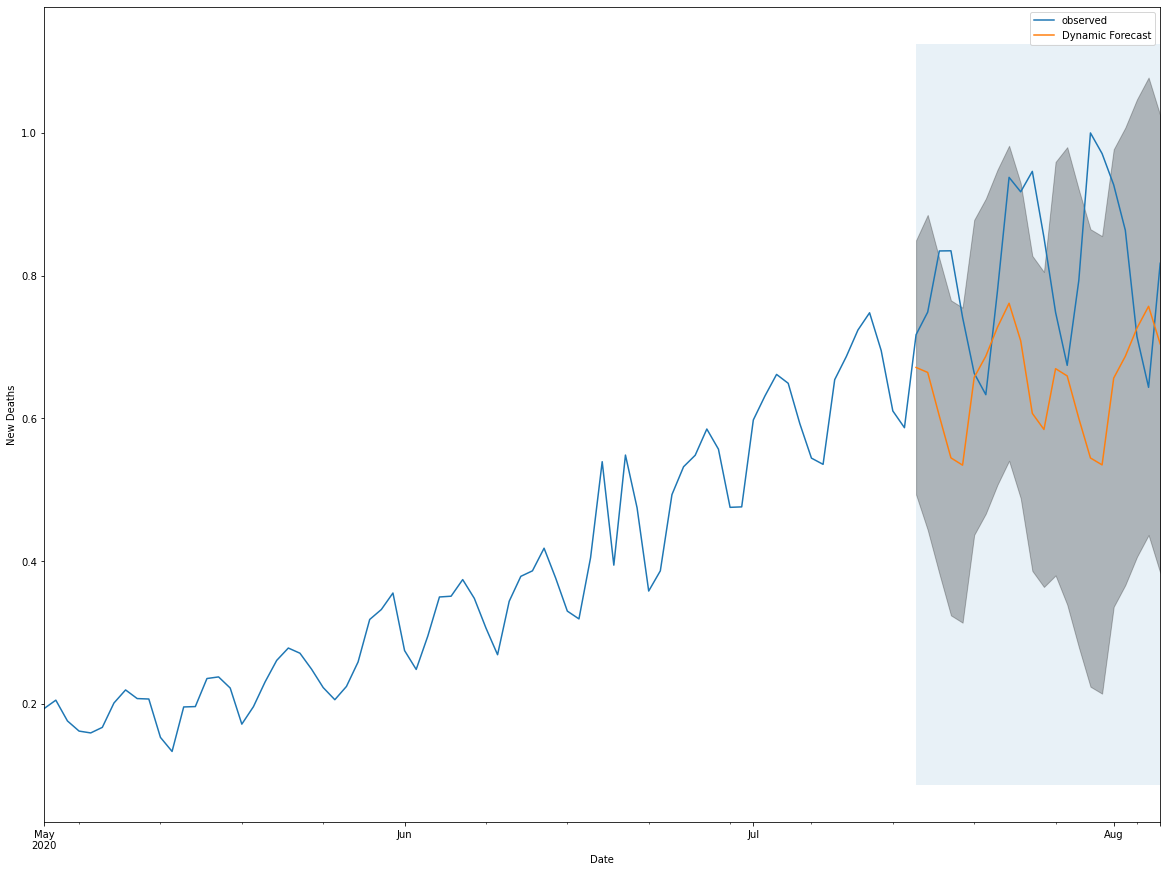

In [36]:
ax = y['2020-05':].plot(label='observed', figsize=(20,15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
               pred_dynamic_ci.iloc[:,0],
               pred_dynamic_ci.iloc[:,1], color='k', alpha=.25)

# ax.fill_between(ax.get_ylim(), pd.to_datetime('2020-07-15'), y.index[-1],
#                alpha=.1, zorder=-1)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2020-07-15'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('New Deaths')

plt.legend()
plt.show()

In [37]:
# y_forecasted = pred_dynamic.predicted_mean
# y_truth = y['2020-07-15':]

# # Compute the mean square error
# mse = ((y_forecasted - y_truth) ** 2).mean()
# print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [38]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

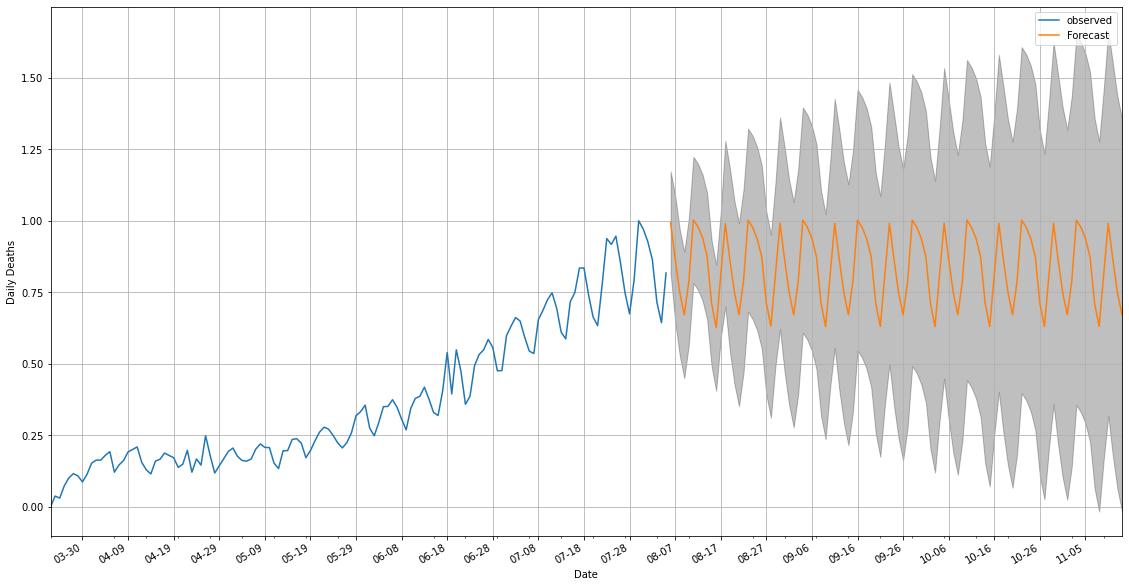

In [39]:
ax = y.plot(label='observed', figsize=(19.20, 10.80))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Daily Deaths')

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.DayLocator(interval=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
plt.gcf().autofmt_xdate()

plt.grid()
plt.legend()
plt.show()